# Symptom, Disease, Physician: Who to Visit When You Are Not Feeling Well?

Abstract: Guidance to patient on visiting to the appropriate department is a crucial task during the patient workflow, which means that patient could receive medical intervention well on time if it is accurrate enough. This project use the classification algorithm, including **logistic regressor, random forest, K neighbours classifier, Support Vector Classifier, Gradient Boosting Classifier, and Gaussian Naive Bayes Classifier**, to establish a model on guiding patient on visiting the corresponding department based on their main common symptom.

The data preprocessing is referred from https://www.kaggle.com/code/ebrahimelgazar/disease-recommendation-system

## 0. Import packages & data (Set up environment when applicable)

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
# !pip install pandasql
import pandasql as ps

# import sqlite3 as lite # maybe this is for google colab
import os
import time

In [63]:
# import machine-learning based general packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# This is for confusion matrix
from sklearn import metrics, model_selection 


In [2]:
# set up the environment (for google colab only)


# the data source
# the corresponding file is available at 
# https://www.kaggle.com/datasets/ebrahimelgazar/doctor-specialist-recommendation-system?select=Symptom_Weights.csv

# If you use google colab, PLEASE put the corresponding csv dataset into the root directory of the colab!!! 
# The file will be deleted everytime in google colab!!! And you might use additional code to setup the environment.

# If you use jupyter lab, make sure that you set the directory to the place where the corresponding csv file located.

# os.getcwd()
# os.chdir('your directory goes here')
# os.listdir()
disease_description = pd.read_csv('Disease_Description.csv')

doctor_specialist = pd.read_csv('Doctor_Specialist.csv')

doctor_versus_disease = pd.read_csv('Doctor_Versus_Disease.csv', encoding='windows-1252',\
                                   header = None, usecols=[0,1], names=['Disease', 'Doctor_Specialist']) # need encoding
# 'utf-8' codec can't decode byte 0xa0 in position 490: invalid start byte
# this table has no title...

original_dataset = pd.read_csv('Original_Dataset.csv')  

symptom_weights = pd.read_csv('Symptom_Weights.csv', header = None, usecols = [0, 1], names = ['Symptom', 'weight'])
# this table also has no title...

In [3]:
# show all columns
pd.set_option('display.max_columns', None)

# 1. EDA

### 1.1 Explore Each Table

Disease description (Disease, Description)

In [4]:
# for jupyter notebook, please use pandasql
# for google colab, please set up a connection before using sqlite3.

# first try...
query = '''
    select * from 
    disease_description
    limit 5;
'''     # disease_description.head()
ps.sqldf(query)

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


In [5]:
print(disease_description.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Disease      41 non-null     object
 1   Description  41 non-null     object
dtypes: object(2)
memory usage: 784.0+ bytes
None


Doctor Specialist (Doctor Specialist)

In [6]:
query = '''
    select * from 
    doctor_specialist
    limit 5
'''   # doctor_specialist.head()
ps.sqldf(query)

,Doctor Specialist
0,Dermatologist
1,Allergist
2,Gastroenterologist
3,Hepatologist
4,Osteopathic


In [7]:
print(doctor_specialist.info())
print(doctor_specialist.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Doctor Specialist  19 non-null     object
dtypes: object(1)
memory usage: 280.0+ bytes
None
(19, 1)


Doctor versus Disease ~~(Drug Reaction, Allergist)~~(Disease, Doctor_Specialist)

In [8]:
query = '''
    select * 
    from 
    doctor_versus_disease
    limit 5
''' # doctor_versus_disease.head()
ps.sqldf(query)

# This table has no title, the corresponding title must be Disease, Doctor Specialist

,Disease,Doctor_Specialist
0,Drug Reaction,Allergist
1,Allergy,Allergist
2,Hypertension,Cardiologist
3,Heart attack,Cardiologist
4,Psoriasis,Dermatologist


In [9]:
doctor_versus_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Disease            41 non-null     object
 1   Doctor_Specialist  41 non-null     object
dtypes: object(2)
memory usage: 784.0+ bytes


original_dataset (Symptom_1 to Symptom 17)

In [10]:
query = '''
    select * from 
    original_dataset
    limit 5
''' # original_dataset.head()
ps.sqldf(query)

# unstructured column-based data, for saving storage
# may be used for train and test

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Fungal infection,itching,skin_rash,dischromic _patches,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [11]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


symptom_weights ~~(abdominal_pain, 1)~~(Symptom, weight)

In [12]:
query = '''
    select * from 
    symptom_weights
    limit 5
''' # symptom_weights.head()

ps.sqldf(query)

# no title, the title sould be Symptom and weight, respectively

,Symptom,weight
0,abdominal_pain,1
1,abnormal_menstruation,2
2,acidity,3
3,acute_liver_failure,4
4,altered_sensorium,5


In [13]:
symptom_weights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Symptom  131 non-null    object
 1   weight   131 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


<Axes: >

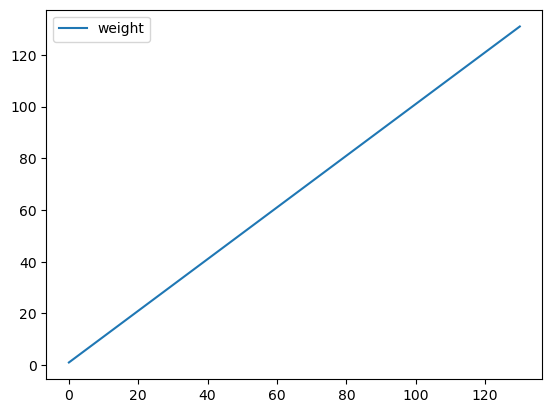

In [14]:
sns.lineplot(symptom_weights)
# as we see, the second column (weight) might be id-liked data

Stage summary: The data generally seems to be clean, with the `original_dataset` contains column-based training and testing dataset. However, the `doctor_versus_disease`and the `symptom_weights` lack of title row, indicating that we should add the title before query.

Therefore, this project rewined to the beginning of the data to modify the reading method of the latter two tables.

Disease description (Disease, Description)<br>
Doctor Specialist (Doctor Specialist)<br>
Doctor versus Disease (Disease, Doctor_Specialist)<br>
original_dataset (Symptom_1 to Symptom 17)<br>
symptom_weights (Symptom, weight)


### Analysis by SQL

1. Browse all the given disease with itching as symptom

In [15]:
query = '''
    select distinct Disease 
    from 
    original_dataset 
    where 
    Symptom_1 = 'itching' or 
    Symptom_2 = 'itching' or
    Symptom_3 = 'itching' or
    Symptom_4 = 'itching' or
    Symptom_5 = 'itching' or
    Symptom_6 = 'itching' or
    Symptom_7 = 'itching' or
    Symptom_8 = 'itching' or
    Symptom_9 = 'itching' or
    Symptom_10 = 'itching' or
    Symptom_11 = 'itching' or
    Symptom_12 = 'itching' or
    Symptom_13 = 'itching' or
    Symptom_14 = 'itching' or
    Symptom_15 = 'itching' or
    Symptom_16 = 'itching' or
    Symptom_17 = 'itching'
'''
ps.sqldf(query)

,Disease
0,Fungal infection
1,Chronic cholestasis
2,Drug Reaction
3,Jaundice
4,Chicken pox
5,Hepatitis B


2. Count how many patient suffering from corresponding syndrome in original dataset

In [16]:
query = '''
    with col1 as
    (
    select Symptom_1 as Symptom, count(Symptom_1) as counts 
    from original_dataset
    group by 
    Symptom_1
    )
    ,
    
    col2 as
    
    (
    select Symptom_2, count(Symptom_2) as counts 
    from original_dataset
    group by 
    Symptom_2
    )
    ,
    
    col3 as
    
    (
    select Symptom_3, count(Symptom_3) as counts 
    from original_dataset
    group by 
    Symptom_3
    )
    ,
    
    col4 as
    
    (
    select Symptom_4, count(Symptom_4) as counts 
    from original_dataset
    group by 
    Symptom_4
    )
    ,
    
    col5 as
    
    (
    select Symptom_5, count(Symptom_5) as counts 
    from original_dataset
    group by 
    Symptom_5
    )
    ,
    
    col6 as
    
    (
    select Symptom_6, count(Symptom_6) as counts 
    from original_dataset
    group by 
    Symptom_6
    )
    ,
    
    col7 as
    
    (
    select Symptom_7, count(Symptom_7) as counts 
    from original_dataset
    group by 
    Symptom_7
    )
    ,
    
    col8 as
    
    (
    select Symptom_8, count(Symptom_8) as counts 
    from original_dataset
    group by 
    Symptom_8
    )
    ,
    
    col9 as
    
    (
    select Symptom_9, count(Symptom_9) as counts 
    from original_dataset
    group by 
    Symptom_9
    )
    ,
    
    col10 as
    
    (
    select Symptom_10, count(Symptom_10) as counts 
    from original_dataset
    group by 
    Symptom_10
    )
    ,
    
    col11 as
    
    (
    select Symptom_11, count(Symptom_11) as counts 
    from original_dataset
    group by 
    Symptom_11
    )
    ,
    
    col12 as
    
    (
    select Symptom_12, count(Symptom_12) as counts 
    from original_dataset
    group by 
    Symptom_12
    )
    ,
    
    col13 as
    
    (
    select Symptom_13, count(Symptom_13) as counts 
    from original_dataset
    group by 
    Symptom_13
    )
    ,
    
    col14 as
    
    (
    select Symptom_14, count(Symptom_14) as counts 
    from original_dataset
    group by 
    Symptom_14
    )
    ,
    
    col15 as
    
    (
    select Symptom_15, count(Symptom_15) as counts 
    from original_dataset
    group by 
    Symptom_15
    )
    ,
    
    col16 as
    
    (
    select Symptom_16, count(Symptom_16) as counts 
    from original_dataset
    group by 
    Symptom_16
    )
    ,
    
    col17 as
    
    (
    select Symptom_17, count(Symptom_17) as counts 
    from original_dataset
    group by 
    Symptom_17
    )    -- DO EXECUTE the code once before adding a similar sub query !!!
    
    -- 1. THIS SUBQUERY IS TO COUNT THE SYMPTOM FOR EACH COLUMN, PLEASE ENSURE THAT THE WITH CLAUSE HAS NO ERROR!!!
    
    select Symptom, sum(counts) as counts_all from  -- 3. THIS IS ACTUALLY THE LAST STEP, TO AGGREGATE THE UNIONED ALL COLUMN QUERY
    
    (select * from col1 union all 
    select * from col2 union all
    select * from col3 union all
    select * from col4 union all
    select * from col5 union all
    select * from col6 union all
    select * from col7 union all
    select * from col8 union all
    select * from col9 union all
    select * from col10 union all
    select * from col11 union all
    select * from col12 union all
    select * from col13 union all
    select * from col14 union all
    select * from col15 union all
    select * from col16 union all
    select * from col17)
    
    -- 2. THIS IS TO UNION ALL THE DISEASE~COUNT PAIR INTO TWO COLUMN BEFORE AGGREGATION
    -- DO NOTE THAT WE MUST NOT DEDUPLICATE THE RECORD, ELSE SOME RECORD MAY GET LOSE!!!
    
    group by Symptom
    order by counts_all desc
    
'''

ps.sqldf(query)



# p.s.: I have tried multiple times to approach each task before duplicating the similar clause, 
# the code seems to be complicated though...

# do try to execute the code after add each column instead of doing it once for all...


,Symptom,counts_all
0,fatigue,1932
1,vomiting,1914
2,high_fever,1362
3,loss_of_appetite,1152
4,nausea,1146
...,...,...
127,dischromic _patches,108
128,dehydration,108
129,blackheads,108
130,foul_smell_of urine,102


<Axes: xlabel='counts_all', ylabel='Symptom'>

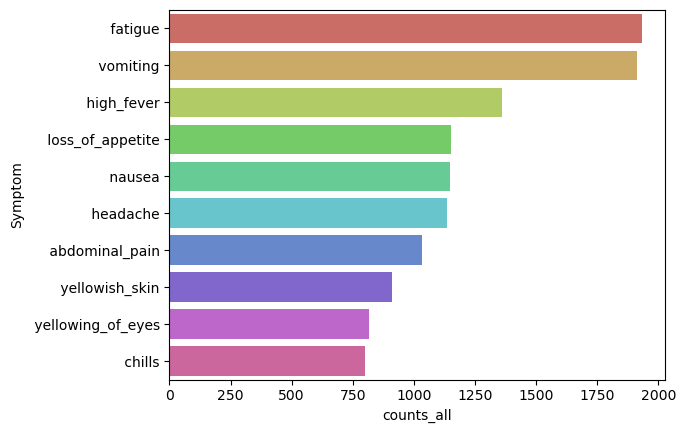

In [17]:
# visulize top 10 frequent symptoms
res = ps.sqldf(query)
sns.barplot(res.iloc[: 10, :], y = 'Symptom', x = 'counts_all', palette = 'hls')


It seems that most patient were suffering from fatigue, vomiting, high fever, apppetite lose, and nausea

*This also implies the disadvantage of sql towards column-based dataset...tedius and duplicative subquereies, repetative union of aggregation, which prone to be errornous*

3. If the patient is suffering from itching, which specialist will they probably visit?

In [18]:
query = '''
    -- 1. select the possible disease with fatigue
    with diseases as 
    (
    select distinct Disease 
    from 
    original_dataset 
    where 
    Symptom_1 = 'itching' or 
    Symptom_2 = 'itching' or
    Symptom_3 = 'itching' or
    Symptom_4 = 'itching' or
    Symptom_5 = 'itching' or
    Symptom_6 = 'itching' or
    Symptom_7 = 'itching' or
    Symptom_8 = 'itching' or
    Symptom_9 = 'itching' or
    Symptom_10 = 'itching' or
    Symptom_11 = 'itching' or
    Symptom_12 = 'itching' or
    Symptom_13 = 'itching' or
    Symptom_14 = 'itching' or
    Symptom_15 = 'itching' or
    Symptom_16 = 'itching' or
    Symptom_17 = 'itching'
    )
    select distinct Doctor_Specialist 
    from original_dataset 
    full join 
    doctor_versus_disease 
    on
    original_dataset.Disease = doctor_versus_disease.Disease
    
    where 
    original_dataset.Disease in 
    (
    select Disease from diseases
    )
    
'''
ps.sqldf(query)

,Doctor_Specialist
0,Dermatologist
1,Hepatologist
2,Allergist
3,Gastroenterologist
4,hepatologist


The patient suffering from itching would possibly go to the Dermatologist, Hepatologist, Allergist, Gastroenterologist, or hepatologist.

### 2. Data preprocessing

This is a **Column-based** dataset. Therefore, we shall convert them to list before undergoing further analysis.

This is also why querying is so tedious through SQL.

In [19]:
# set a new column, 'Symptoms', in the end
original_dataset['Symptoms'] = 0
original_dataset.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Symptoms
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [20]:
# the new column, Symptoms shall store the list-based symptoms corresponding to different patient

for i in range(original_dataset.shape[0]): # by N of row
    value = original_dataset.iloc[i].tolist() # transfer entire row into list
    original_dataset["Symptoms"][i] = value[1:18] # exclude title & last 0, only include 17 symptoms in between


C:\Users\Raymo\AppData\Local\Temp\ipykernel_8708\2226175210.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_dataset["Symptoms"][i] = value[1:18] # exclude title & last 0, only include 17 symptoms in between


<font color = 'red'>**Warning!! once we add a column storing lists, pandasql would not work!!!**</font>

In [21]:
original_dataset.head() # the last column consists of all the 17 symptoms

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Symptoms
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, nodal_skin_eruptions, ..."
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[ skin_rash, nodal_skin_eruptions, dischromi..."
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, nodal_skin_eruptions, dischromic _..."
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, dischromic _patches, na..."
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, nodal_skin_eruptions, n..."


In [22]:
column_values = original_dataset[['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4',
       'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9',
       'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14',
       'Symptom_15', 'Symptom_16', 'Symptom_17']].values.ravel()  # change data therein into a list



In [23]:
# count the total number of symptoms
symps = pd.unique(column_values).tolist()  
# print(len(symps)) # 132, has a nan
symps = [i for i in symps if str(i) != "nan"] # remove 'nan'

print(len(symps))

131


`ravel data` -> `unique value` -> `tolist` -> `remove nan`<br>
There are 131 symptoms here, identical to sql analysis that has been previously conducted

In [24]:
new_data = symptoms = pd.DataFrame(columns = symps ,index = original_dataset.index)
# this is done to set unique symptoms as column instead, while the row index is corresponds to the original dataset.
# and create two copies

In [25]:
new_data.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,ulcers_on_tongue,vomiting,cough,chest_pain,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,burning_micturition,spotting_ urination,passage_of_gases,internal_itching,indigestion,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,fatigue,weight_loss,restlessness,lethargy,irregular_sugar_level,blurred_and_distorted_vision,obesity,excessive_hunger,increased_appetite,polyuria,sunken_eyes,dehydration,diarrhoea,breathlessness,family_history,mucoid_sputum,headache,dizziness,loss_of_balance,lack_of_concentration,stiff_neck,depression,irritability,visual_disturbances,back_pain,weakness_in_limbs,neck_pain,weakness_of_one_body_side,altered_sensorium,dark_urine,sweating,muscle_pain,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,joint_pain,pain_behind_the_eyes,constipation,toxic_look_(typhos),belly_pain,yellow_urine,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,acute_liver_failure,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,phlegm,blood_in_sputum,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,loss_of_smell,fast_heart_rate,rusty_sputum,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,cramps,bruising,swollen_legs,swollen_blood_vessels,prominent_veins_on_calf,weight_gain,cold_hands_and_feets,mood_swings,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,abnormal_menstruation,muscle_weakness,anxiety,slurred_speech,palpitations,drying_and_tingling_lips,knee_pain,hip_joint_pain,swelling_joints,painful_walking,movement_stiffness,spinning_movements,unsteadiness,pus_filled_pimples,blackheads,scurring,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [26]:
new_data.tail()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,ulcers_on_tongue,vomiting,cough,chest_pain,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,burning_micturition,spotting_ urination,passage_of_gases,internal_itching,indigestion,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,fatigue,weight_loss,restlessness,lethargy,irregular_sugar_level,blurred_and_distorted_vision,obesity,excessive_hunger,increased_appetite,polyuria,sunken_eyes,dehydration,diarrhoea,breathlessness,family_history,mucoid_sputum,headache,dizziness,loss_of_balance,lack_of_concentration,stiff_neck,depression,irritability,visual_disturbances,back_pain,weakness_in_limbs,neck_pain,weakness_of_one_body_side,altered_sensorium,dark_urine,sweating,muscle_pain,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,joint_pain,pain_behind_the_eyes,constipation,toxic_look_(typhos),belly_pain,yellow_urine,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,acute_liver_failure,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,phlegm,blood_in_sputum,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,loss_of_smell,fast_heart_rate,rusty_sputum,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,cramps,bruising,swollen_legs,swollen_blood_vessels,prominent_veins_on_calf,weight_gain,cold_hands_and_feets,mood_swings,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,abnormal_menstruation,muscle_weakness,anxiety,slurred_speech,palpitations,drying_and_tingling_lips,knee_pain,hip_joint_pain,swelling_joints,painful_walking,movement_stiffness,spinning_movements,unsteadiness,pus_filled_pimples,blackheads,scurring,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
4915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [27]:
symptoms["Symptoms"] = original_dataset["Symptoms"] 

The copy of `symptoms` is to store and fill the corresponding symptom into the column. <br>
By one-hot way

In [28]:
symptoms.head() 

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,ulcers_on_tongue,vomiting,cough,chest_pain,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,burning_micturition,spotting_ urination,passage_of_gases,internal_itching,indigestion,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,fatigue,weight_loss,restlessness,lethargy,irregular_sugar_level,blurred_and_distorted_vision,obesity,excessive_hunger,increased_appetite,polyuria,sunken_eyes,dehydration,diarrhoea,breathlessness,family_history,mucoid_sputum,headache,dizziness,loss_of_balance,lack_of_concentration,stiff_neck,depression,irritability,visual_disturbances,back_pain,weakness_in_limbs,neck_pain,weakness_of_one_body_side,altered_sensorium,dark_urine,sweating,muscle_pain,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,joint_pain,pain_behind_the_eyes,constipation,toxic_look_(typhos),belly_pain,yellow_urine,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,acute_liver_failure,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,phlegm,blood_in_sputum,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,loss_of_smell,fast_heart_rate,rusty_sputum,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,cramps,bruising,swollen_legs,swollen_blood_vessels,prominent_veins_on_calf,weight_gain,cold_hands_and_feets,mood_swings,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,abnormal_menstruation,muscle_weakness,anxiety,slurred_speech,palpitations,drying_and_tingling_lips,knee_pain,hip_joint_pain,swelling_joints,painful_walking,movement_stiffness,spinning_movements,unsteadiness,pus_filled_pimples,blackheads,scurring,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Symptoms
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, nodal_skin_eruptions, ..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[ skin_rash, nodal_skin_eruptions, dischromi..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, nodal_skin_eruptions, dischromic _..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [29]:
for i in symps:
    symptoms[i] = symptoms.apply(lambda x:1 if i in x.Symptoms else 0, axis=1)  # fill the symptom by one-hot way

In [30]:
symptoms.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,ulcers_on_tongue,vomiting,cough,chest_pain,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,burning_micturition,spotting_ urination,passage_of_gases,internal_itching,indigestion,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,fatigue,weight_loss,restlessness,lethargy,irregular_sugar_level,blurred_and_distorted_vision,obesity,excessive_hunger,increased_appetite,polyuria,sunken_eyes,dehydration,diarrhoea,breathlessness,family_history,mucoid_sputum,headache,dizziness,loss_of_balance,lack_of_concentration,stiff_neck,depression,irritability,visual_disturbances,back_pain,weakness_in_limbs,neck_pain,weakness_of_one_body_side,altered_sensorium,dark_urine,sweating,muscle_pain,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,joint_pain,pain_behind_the_eyes,constipation,toxic_look_(typhos),belly_pain,yellow_urine,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,acute_liver_failure,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,phlegm,blood_in_sputum,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,loss_of_smell,fast_heart_rate,rusty_sputum,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,cramps,bruising,swollen_legs,swollen_blood_vessels,prominent_veins_on_calf,weight_gain,cold_hands_and_feets,mood_swings,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,abnormal_menstruation,muscle_weakness,anxiety,slurred_speech,palpitations,drying_and_tingling_lips,knee_pain,hip_joint_pain,swelling_joints,painful_walking,movement_stiffness,spinning_movements,unsteadiness,pus_filled_pimples,blackheads,scurring,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Symptoms
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[itching, skin_rash, nodal_skin_eruptions, ..."
1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[ skin_rash, nodal_skin_eruptions, dischromi..."
2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[itching, nodal_skin_eruptions, dischromic _..."
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[itching, skin_rash, dischromic _patches, na..."
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[itching, skin_rash, nodal_skin_eruptions, n..."


In [31]:
symptoms["Disease"] = original_dataset["Disease"] # add a Disease column into symptoms table
symptoms = symptoms.drop("Symptoms",axis=1) # drop the original list-stored columns
symptoms.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,ulcers_on_tongue,vomiting,cough,chest_pain,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,burning_micturition,spotting_ urination,passage_of_gases,internal_itching,indigestion,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,fatigue,weight_loss,restlessness,lethargy,irregular_sugar_level,blurred_and_distorted_vision,obesity,excessive_hunger,increased_appetite,polyuria,sunken_eyes,dehydration,diarrhoea,breathlessness,family_history,mucoid_sputum,headache,dizziness,loss_of_balance,lack_of_concentration,stiff_neck,depression,irritability,visual_disturbances,back_pain,weakness_in_limbs,neck_pain,weakness_of_one_body_side,altered_sensorium,dark_urine,sweating,muscle_pain,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,joint_pain,pain_behind_the_eyes,constipation,toxic_look_(typhos),belly_pain,yellow_urine,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,acute_liver_failure,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,phlegm,blood_in_sputum,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,loss_of_smell,fast_heart_rate,rusty_sputum,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,cramps,bruising,swollen_legs,swollen_blood_vessels,prominent_veins_on_calf,weight_gain,cold_hands_and_feets,mood_swings,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,abnormal_menstruation,muscle_weakness,anxiety,slurred_speech,palpitations,drying_and_tingling_lips,knee_pain,hip_joint_pain,swelling_joints,painful_walking,movement_stiffness,spinning_movements,unsteadiness,pus_filled_pimples,blackheads,scurring,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Disease
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection


In [43]:
# this query is to concatinate the corresponding physician into the one-hot-encoded symptom-disease table
query = '''
    select * from
    symptoms 
    full join 
    doctor_versus_disease 
    on 
    symptoms.Disease = doctor_versus_disease.Disease
    
'''

analyze_data = ps.sqldf(query)

In [44]:
analyze_data.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,ulcers_on_tongue,vomiting,cough,chest_pain,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,burning_micturition,spotting_ urination,passage_of_gases,internal_itching,indigestion,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,fatigue,weight_loss,restlessness,lethargy,irregular_sugar_level,blurred_and_distorted_vision,obesity,excessive_hunger,increased_appetite,polyuria,sunken_eyes,dehydration,diarrhoea,breathlessness,family_history,mucoid_sputum,headache,dizziness,loss_of_balance,lack_of_concentration,stiff_neck,depression,irritability,visual_disturbances,back_pain,weakness_in_limbs,neck_pain,weakness_of_one_body_side,altered_sensorium,dark_urine,sweating,muscle_pain,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,joint_pain,pain_behind_the_eyes,constipation,toxic_look_(typhos),belly_pain,yellow_urine,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,acute_liver_failure,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,phlegm,blood_in_sputum,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,loss_of_smell,fast_heart_rate,rusty_sputum,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,cramps,bruising,swollen_legs,swollen_blood_vessels,prominent_veins_on_calf,weight_gain,cold_hands_and_feets,mood_swings,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,abnormal_menstruation,muscle_weakness,anxiety,slurred_speech,palpitations,drying_and_tingling_lips,knee_pain,hip_joint_pain,swelling_joints,painful_walking,movement_stiffness,spinning_movements,unsteadiness,pus_filled_pimples,blackheads,scurring,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Disease,Disease,Doctor_Specialist
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,Fungal infection,Dermatologist
1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,Fungal infection,Dermatologist
2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,Fungal infection,Dermatologist
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,Fungal infection,Dermatologist
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,Fungal infection,Dermatologist


In [48]:
analyze_data['Doctor_Specialist'].info() # every cell in Doctor_Specialist are unnull

<class 'pandas.core.series.Series'>
RangeIndex: 4920 entries, 0 to 4919
Series name: Doctor_Specialist
Non-Null Count  Dtype 
--------------  ----- 
4920 non-null   object
dtypes: object(1)
memory usage: 38.6+ KB


In [46]:
analyze_data.describe()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,ulcers_on_tongue,vomiting,cough,chest_pain,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,burning_micturition,spotting_ urination,passage_of_gases,internal_itching,indigestion,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,fatigue,weight_loss,restlessness,lethargy,irregular_sugar_level,blurred_and_distorted_vision,obesity,excessive_hunger,increased_appetite,polyuria,sunken_eyes,dehydration,diarrhoea,breathlessness,family_history,mucoid_sputum,headache,dizziness,loss_of_balance,lack_of_concentration,stiff_neck,depression,irritability,visual_disturbances,back_pain,weakness_in_limbs,neck_pain,weakness_of_one_body_side,altered_sensorium,dark_urine,sweating,muscle_pain,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,joint_pain,pain_behind_the_eyes,constipation,toxic_look_(typhos),belly_pain,yellow_urine,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,acute_liver_failure,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,phlegm,blood_in_sputum,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,loss_of_smell,fast_heart_rate,rusty_sputum,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,cramps,bruising,swollen_legs,swollen_blood_vessels,prominent_veins_on_calf,weight_gain,cold_hands_and_feets,mood_swings,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,abnormal_menstruation,muscle_weakness,anxiety,slurred_speech,palpitations,drying_and_tingling_lips,knee_pain,hip_joint_pain,swelling_joints,painful_walking,movement_stiffness,spinning_movements,unsteadiness,pus_filled_pimples,blackheads,scurring,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
count,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000
mean,0.137805,0.159756,0.021951,0.021951,0.045122,0.021951,0.162195,0.021951,0.045122,0.045122,0.021951,0.389024,0.114634,0.141463,0.185366,0.232927,0.234146,0.209756,0.165854,0.043902,0.021951,0.023171,0.023171,0.045122,0.021951,0.021951,0.276829,0.021951,0.392683,0.092683,0.046341,0.092683,0.023171,0.069512,0.046341,0.093902,0.024390,0.024390,0.021951,0.021951,0.114634,0.091463,0.046341,

In [51]:
guidance = analyze_data.drop('Disease', axis = 1)

In [52]:
guidance.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,ulcers_on_tongue,vomiting,cough,chest_pain,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,burning_micturition,spotting_ urination,passage_of_gases,internal_itching,indigestion,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,fatigue,weight_loss,restlessness,lethargy,irregular_sugar_level,blurred_and_distorted_vision,obesity,excessive_hunger,increased_appetite,polyuria,sunken_eyes,dehydration,diarrhoea,breathlessness,family_history,mucoid_sputum,headache,dizziness,loss_of_balance,lack_of_concentration,stiff_neck,depression,irritability,visual_disturbances,back_pain,weakness_in_limbs,neck_pain,weakness_of_one_body_side,altered_sensorium,dark_urine,sweating,muscle_pain,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,joint_pain,pain_behind_the_eyes,constipation,toxic_look_(typhos),belly_pain,yellow_urine,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,acute_liver_failure,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,phlegm,blood_in_sputum,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,loss_of_smell,fast_heart_rate,rusty_sputum,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,cramps,bruising,swollen_legs,swollen_blood_vessels,prominent_veins_on_calf,weight_gain,cold_hands_and_feets,mood_swings,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,abnormal_menstruation,muscle_weakness,anxiety,slurred_speech,palpitations,drying_and_tingling_lips,knee_pain,hip_joint_pain,swelling_joints,painful_walking,movement_stiffness,spinning_movements,unsteadiness,pus_filled_pimples,blackheads,scurring,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Doctor_Specialist
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Dermatologist
1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Dermatologist
2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Dermatologist
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Dermatologist
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Dermatologist


C:\Users\Raymo\AppData\Local\Temp\ipykernel_8708\1612129419.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = guidance.corr()


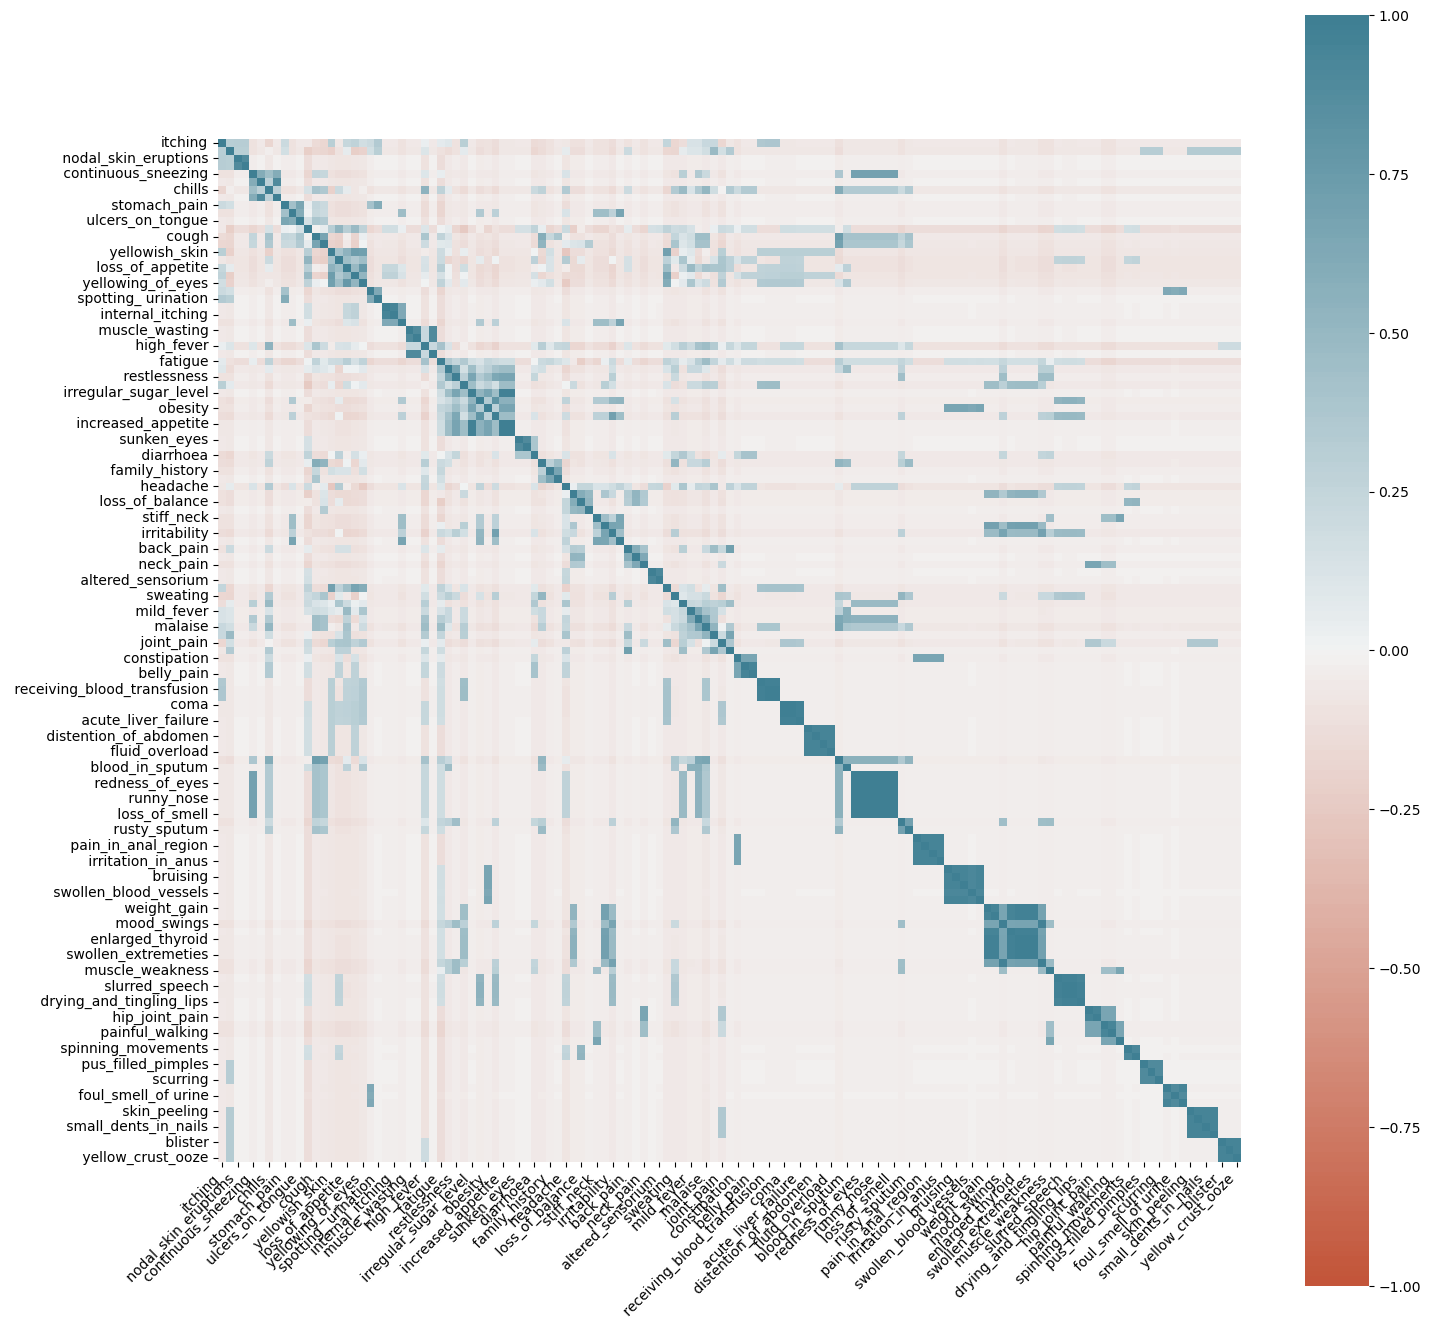

In [62]:
# see correlations between symptoms
plt.figure(figsize = (16.5, 16.5))
corr = guidance.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot = False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()


Some Symptoms are closely correlated, <font color='red'>medically</font>

# Model 1 Train the model for `inpatient guidance`

### 3. Model Training & Testing

The `guidance` dataset stores the symptoms corresponding to the physician that cope with such a disease

In [54]:
# Train-test split
x = guidance.drop('Doctor_Specialist', axis = 1)
y = guidance.Doctor_Specialist

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state = 22)

In [65]:
# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

# Support Vector Classification
classifier_SVC = SVC(probability=True)

# GB classifier
classifier_GB = GradientBoostingClassifier()

# Gaussian Naive Bayes
classifier_NB = GaussianNB()

We shall use Logistic Regression, Random Forest Classifier, KNeighborsClassifier, SVC, GradientBoostingClassifier, and 

Workflow:<br>
`fit model` -> `predict result by training dataset` -> `cross validation` -> `get cross validation result` -> `plot confusion matrix`

Logistic Regression

For Logistic Regression, the accurracy is 100.0 +/- 0.0%


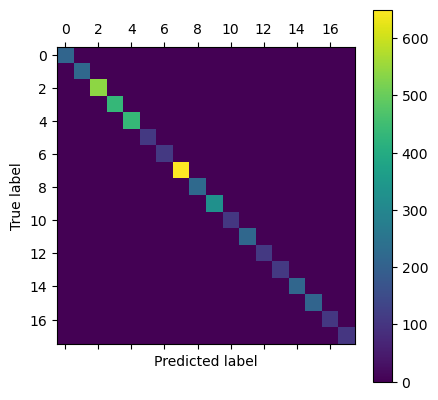

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00       211
       Cardiologist       1.00      1.00      1.00       219
      Dermatologist       1.00      1.00      1.00       539
    Endocrinologist       1.00      1.00      1.00       434
 Gastroenterologist       1.00      1.00      1.00       436
Gastroenterologist        1.00      1.00      1.00       109
       Gynecologist       1.00      1.00      1.00       108
       Hepatologist       1.00      1.00      1.00       650
   Internal Medcine       1.00      1.00      1.00       222
        Neurologist       1.00      1.00      1.00       327
        Osteopathic       1.00      1.00      1.00       106
   Otolaryngologist       1.00      1.00      1.00       217
       Pediatrician       1.00      1.00      1.00       108
       Phlebologist       1.00      1.00      1.00       108
      Pulmonologist       1.00      1.00      1.00       215
    Rheumatologists    

In [71]:
classifier_logistic.fit(x_train, y_train)
y_predict = classifier_logistic.predict(x_train) # predict the result

scores = model_selection.cross_val_score(classifier_logistic, x_train, y_train, cv = 10)
print(f'For Logistic Regression, the accurracy is {round(scores.mean() * 100, 1)} +/- {round(scores.std() * 100 / (10 ** 0.5) * 1.96, 1)}%')

# Confusion Matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

<font color='red'> A logistic regressor could overkill this task...**Shall we continue to use a more complexed model?**</font>

In principle, maybe we can just use a logistic regressor if its test result is also very ideal. But for **Etudie**, we also use other classifier instead

<font color='blue'>The following training and cross validation may for etudie purpose only</font>

RandomForestClassifier

For Random Forest, the accurracy is 100.0 +/- 0.0%


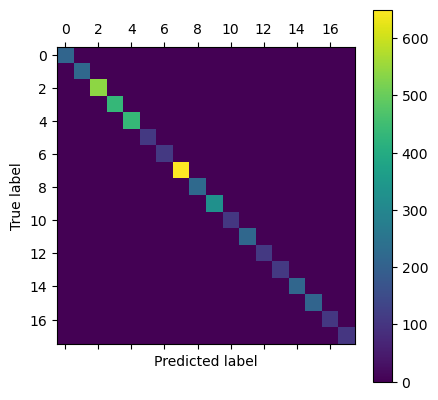

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00       211
       Cardiologist       1.00      1.00      1.00       219
      Dermatologist       1.00      1.00      1.00       539
    Endocrinologist       1.00      1.00      1.00       434
 Gastroenterologist       1.00      1.00      1.00       436
Gastroenterologist        1.00      1.00      1.00       109
       Gynecologist       1.00      1.00      1.00       108
       Hepatologist       1.00      1.00      1.00       650
   Internal Medcine       1.00      1.00      1.00       222
        Neurologist       1.00      1.00      1.00       327
        Osteopathic       1.00      1.00      1.00       106
   Otolaryngologist       1.00      1.00      1.00       217
       Pediatrician       1.00      1.00      1.00       108
       Phlebologist       1.00      1.00      1.00       108
      Pulmonologist       1.00      1.00      1.00       215
    Rheumatologists    

In [73]:
classifier_RF.fit(x_train, y_train)
y_predict = classifier_RF.predict(x_train) # predict the result

scores = model_selection.cross_val_score(classifier_RF, x_train, y_train, cv = 10)
print(f'For Random Forest, the accurracy is {round(scores.mean() * 100, 1)} +/- {round(scores.std() * 100 / (10 ** 0.5) * 1.96, 1)}%')

# Confusion Matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

KNeighborsClassifier

For K-Neighbours Classifier, the accurracy is 100.0 +/- 0.0


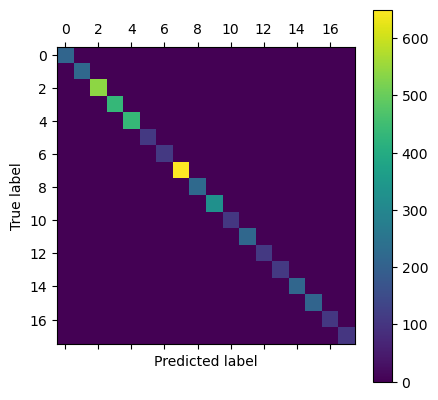

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00       211
       Cardiologist       1.00      1.00      1.00       219
      Dermatologist       1.00      1.00      1.00       539
    Endocrinologist       1.00      1.00      1.00       434
 Gastroenterologist       1.00      1.00      1.00       436
Gastroenterologist        1.00      1.00      1.00       109
       Gynecologist       1.00      1.00      1.00       108
       Hepatologist       1.00      1.00      1.00       650
   Internal Medcine       1.00      1.00      1.00       222
        Neurologist       1.00      1.00      1.00       327
        Osteopathic       1.00      1.00      1.00       106
   Otolaryngologist       1.00      1.00      1.00       217
       Pediatrician       1.00      1.00      1.00       108
       Phlebologist       1.00      1.00      1.00       108
      Pulmonologist       1.00      1.00      1.00       215
    Rheumatologists    

In [77]:
classifier_KNN.fit(x_train, y_train)
y_predict = classifier_KNN.predict(x_train)

scores = model_selection.cross_val_score(classifier_KNN, x_train, y_train, cv = 10)
print(f'For K-Neighbours Classifier, the accurracy is {round(scores.mean() * 100 ,2)} +/- {round(scores.std() / (10 ** 0.5) * 1.96, 2)}')

# Confusion Matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

SVC

For SVC, the classification accurracy is 100.0 +/- 0.0


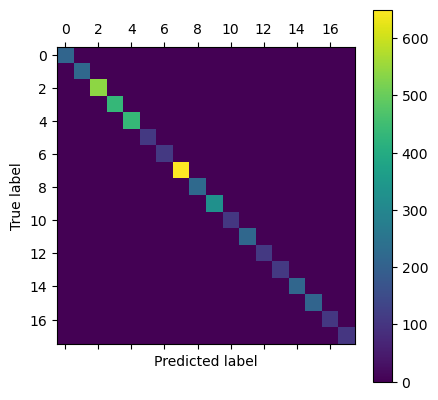

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00       211
       Cardiologist       1.00      1.00      1.00       219
      Dermatologist       1.00      1.00      1.00       539
    Endocrinologist       1.00      1.00      1.00       434
 Gastroenterologist       1.00      1.00      1.00       436
Gastroenterologist        1.00      1.00      1.00       109
       Gynecologist       1.00      1.00      1.00       108
       Hepatologist       1.00      1.00      1.00       650
   Internal Medcine       1.00      1.00      1.00       222
        Neurologist       1.00      1.00      1.00       327
        Osteopathic       1.00      1.00      1.00       106
   Otolaryngologist       1.00      1.00      1.00       217
       Pediatrician       1.00      1.00      1.00       108
       Phlebologist       1.00      1.00      1.00       108
      Pulmonologist       1.00      1.00      1.00       215
    Rheumatologists    

In [81]:
classifier_SVC.fit(x_train, y_train)
y_predict = classifier_SVC.predict(x_train)

# cross validation
scores = model_selection.cross_val_score(classifier_SVC, x_train, y_train, cv = 10)
print(f'For SVC, the classification accurracy is {round(scores.mean() * 100, 2)} +/- {round(scores.std() / (10 ** 0.5) * 1.96, 2)}')

# confusion matrix 
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

*The model is a bit slow*

GradientBoostingClassifier

In [84]:
classifier_GB.fit(x_train, y_train)
y_predict = classifier_GB.predict(x_train)

# cross validation
scores = model_selection.cross_val_score(classifier_GB, x_train, y_train, cv = 10)

print(f'For Gradient Boosting Classifier, the accurracy is {round(scores.mean() * 100 , 2)}\
    +/- {round(scores.std() * 1.96 / (10 ** 0.5), 2)}%')

For Gradient Boosting Classifier, the accurracy is 100.0    +/- 0.0%


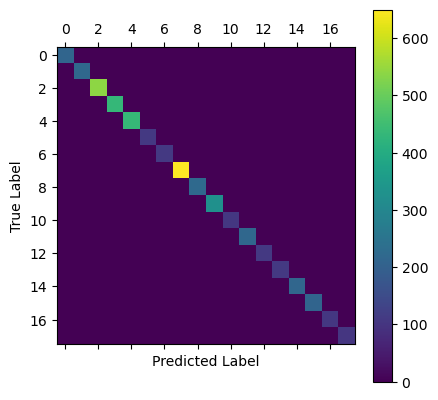

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00       211
       Cardiologist       1.00      1.00      1.00       219
      Dermatologist       1.00      1.00      1.00       539
    Endocrinologist       1.00      1.00      1.00       434
 Gastroenterologist       1.00      1.00      1.00       436
Gastroenterologist        1.00      1.00      1.00       109
       Gynecologist       1.00      1.00      1.00       108
       Hepatologist       1.00      1.00      1.00       650
   Internal Medcine       1.00      1.00      1.00       222
        Neurologist       1.00      1.00      1.00       327
        Osteopathic       1.00      1.00      1.00       106
   Otolaryngologist       1.00      1.00      1.00       217
       Pediatrician       1.00      1.00      1.00       108
       Phlebologist       1.00      1.00      1.00       108
      Pulmonologist       1.00      1.00      1.00       215
    Rheumatologists    

In [107]:
# plotting confusing matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

*This model is much slower...*

GaussianNB

In [87]:
classifier_NB.fit(x_train, y_train)
y_predict = classifier_NB.predict(x_train)

# Cross Validation
scores = model_selection.cross_val_score(classifier_NB, x_train, y_train, cv = 10)
print(f'Fore Gaussian Naive Bayes Model, the accurracy is {round(scores.mean() * 100, 2)} +/- {round(scores.std() * 1.96 / (10 ** 0.5), 2)}')

Fore Gaussian Naive Bayes Model, the accurracy is 100.0 +/- 0.0


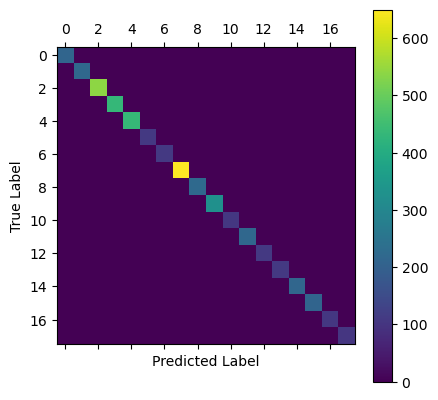

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00       211
       Cardiologist       1.00      1.00      1.00       219
      Dermatologist       1.00      1.00      1.00       539
    Endocrinologist       1.00      1.00      1.00       434
 Gastroenterologist       1.00      1.00      1.00       436
Gastroenterologist        1.00      1.00      1.00       109
       Gynecologist       1.00      1.00      1.00       108
       Hepatologist       1.00      1.00      1.00       650
   Internal Medcine       1.00      1.00      1.00       222
        Neurologist       1.00      1.00      1.00       327
        Osteopathic       1.00      1.00      1.00       106
   Otolaryngologist       1.00      1.00      1.00       217
       Pediatrician       1.00      1.00      1.00       108
       Phlebologist       1.00      1.00      1.00       108
      Pulmonologist       1.00      1.00      1.00       215
    Rheumatologists    

In [108]:
# confusion matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(metrics.classification_report(y_train, y_predict))

All of the models above, including logistic regression, are overfitted. Let's see what they perform in test model.

### 4. Model Evaluation
**Precision**(PPV, positive predictive value): <font color='red'>tp / (tp + fp)</font>;
High Precision means low fp

**Recall**(sensitivity, hit rate, true positive rate): <font color='red'>tp / (tp + fn)</font>

**Accurracy**: <font color='red'>(tp + tn) / (tp + tn + fp + fn)</font>

**f1-Score**: <font color='red'>(2 * P * R) / (P + R)</font>

1. Logistic Regression

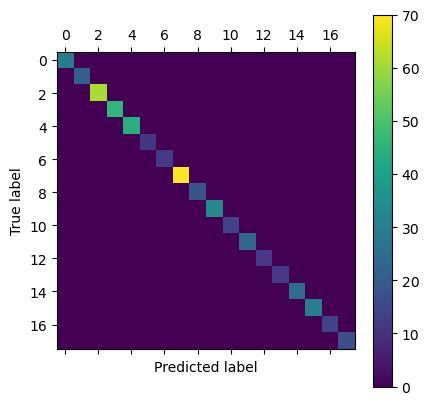

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00        29
       Cardiologist       1.00      1.00      1.00        21
      Dermatologist       1.00      1.00      1.00        61
    Endocrinologist       1.00      1.00      1.00        46
 Gastroenterologist       1.00      1.00      1.00        44
Gastroenterologist        1.00      1.00      1.00        11
       Gynecologist       1.00      1.00      1.00        12
       Hepatologist       1.00      1.00      1.00        70
   Internal Medcine       1.00      1.00      1.00        18
        Neurologist       1.00      1.00      1.00        33
        Osteopathic       1.00      1.00      1.00        14
   Otolaryngologist       1.00      1.00      1.00        23
       Pediatrician       1.00      1.00      1.00        12
       Phlebologist       1.00      1.00      1.00        12
      Pulmonologist       1.00      1.00      1.00        25
    Rheumatologists    

In [97]:
y_final_predict = classifier_logistic.predict(x_test)

cm = metrics.confusion_matrix(y_test, y_final_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_test, y_final_predict))


**If we only use patient symptom data for guidance to the corresponding department, a logistic regression might be enough...**

2. RandomForestClassifier

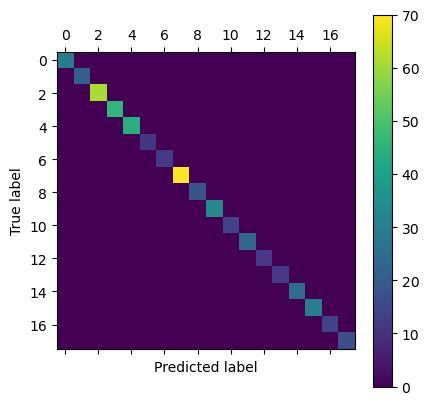

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00        29
       Cardiologist       1.00      1.00      1.00        21
      Dermatologist       1.00      1.00      1.00        61
    Endocrinologist       1.00      1.00      1.00        46
 Gastroenterologist       1.00      1.00      1.00        44
Gastroenterologist        1.00      1.00      1.00        11
       Gynecologist       1.00      1.00      1.00        12
       Hepatologist       1.00      1.00      1.00        70
   Internal Medcine       1.00      1.00      1.00        18
        Neurologist       1.00      1.00      1.00        33
        Osteopathic       1.00      1.00      1.00        14
   Otolaryngologist       1.00      1.00      1.00        23
       Pediatrician       1.00      1.00      1.00        12
       Phlebologist       1.00      1.00      1.00        12
      Pulmonologist       1.00      1.00      1.00        25
    Rheumatologists    

In [100]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, classifier_RF.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_test, classifier_RF.predict(x_test)))

3. KNeighborsClassifier

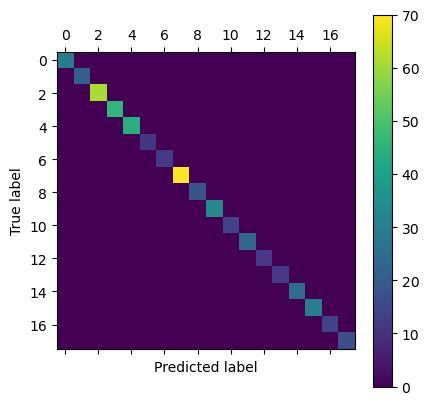

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00        29
       Cardiologist       1.00      1.00      1.00        21
      Dermatologist       1.00      1.00      1.00        61
    Endocrinologist       1.00      1.00      1.00        46
 Gastroenterologist       1.00      1.00      1.00        44
Gastroenterologist        1.00      1.00      1.00        11
       Gynecologist       1.00      1.00      1.00        12
       Hepatologist       1.00      1.00      1.00        70
   Internal Medcine       1.00      1.00      1.00        18
        Neurologist       1.00      1.00      1.00        33
        Osteopathic       1.00      1.00      1.00        14
   Otolaryngologist       1.00      1.00      1.00        23
       Pediatrician       1.00      1.00      1.00        12
       Phlebologist       1.00      1.00      1.00        12
      Pulmonologist       1.00      1.00      1.00        25
    Rheumatologists    

In [102]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, classifier_KNN.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_test, classifier_KNN.predict(x_test)))

4. SVC

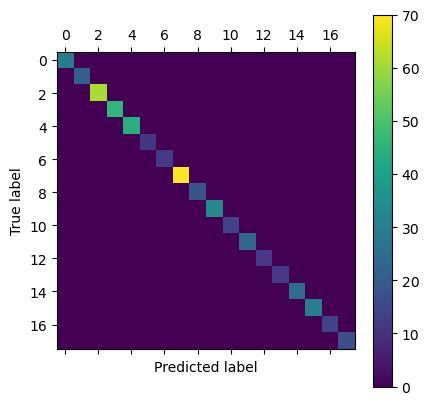

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00        29
       Cardiologist       1.00      1.00      1.00        21
      Dermatologist       1.00      1.00      1.00        61
    Endocrinologist       1.00      1.00      1.00        46
 Gastroenterologist       1.00      1.00      1.00        44
Gastroenterologist        1.00      1.00      1.00        11
       Gynecologist       1.00      1.00      1.00        12
       Hepatologist       1.00      1.00      1.00        70
   Internal Medcine       1.00      1.00      1.00        18
        Neurologist       1.00      1.00      1.00        33
        Osteopathic       1.00      1.00      1.00        14
   Otolaryngologist       1.00      1.00      1.00        23
       Pediatrician       1.00      1.00      1.00        12
       Phlebologist       1.00      1.00      1.00        12
      Pulmonologist       1.00      1.00      1.00        25
    Rheumatologists    

In [106]:
# confusion matrix 
cm = metrics.confusion_matrix(y_test, classifier_SVC.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_test, classifier_SVC.predict(x_test)))

*The model is a bit slow*

5. GradientBoostingClassifier

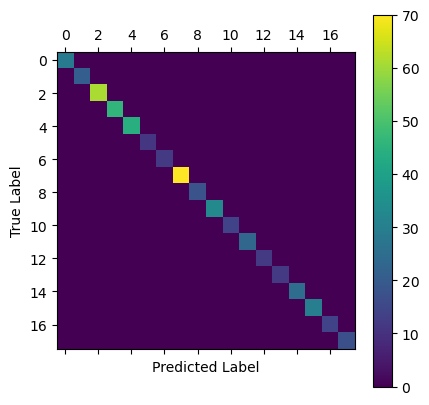

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00        29
       Cardiologist       1.00      1.00      1.00        21
      Dermatologist       1.00      1.00      1.00        61
    Endocrinologist       1.00      1.00      1.00        46
 Gastroenterologist       1.00      1.00      1.00        44
Gastroenterologist        1.00      1.00      1.00        11
       Gynecologist       1.00      1.00      1.00        12
       Hepatologist       1.00      1.00      1.00        70
   Internal Medcine       1.00      1.00      1.00        18
        Neurologist       1.00      1.00      1.00        33
        Osteopathic       1.00      1.00      1.00        14
   Otolaryngologist       1.00      1.00      1.00        23
       Pediatrician       1.00      1.00      1.00        12
       Phlebologist       1.00      1.00      1.00        12
      Pulmonologist       1.00      1.00      1.00        25
    Rheumatologists    

In [111]:
# plotting confusing matrix
cm = metrics.confusion_matrix(y_test, classifier_GB.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(metrics.classification_report(y_test, classifier_GB.predict(x_test)))

*This model is much slower...*

GaussianNB

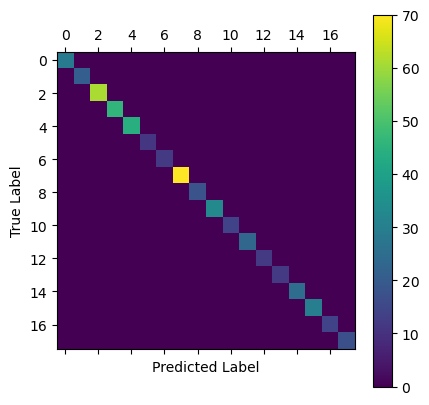

                     precision    recall  f1-score   support

          Allergist       1.00      1.00      1.00        29
       Cardiologist       1.00      1.00      1.00        21
      Dermatologist       1.00      1.00      1.00        61
    Endocrinologist       1.00      1.00      1.00        46
 Gastroenterologist       1.00      1.00      1.00        44
Gastroenterologist        1.00      1.00      1.00        11
       Gynecologist       1.00      1.00      1.00        12
       Hepatologist       1.00      1.00      1.00        70
   Internal Medcine       1.00      1.00      1.00        18
        Neurologist       1.00      1.00      1.00        33
        Osteopathic       1.00      1.00      1.00        14
   Otolaryngologist       1.00      1.00      1.00        23
       Pediatrician       1.00      1.00      1.00        12
       Phlebologist       1.00      1.00      1.00        12
      Pulmonologist       1.00      1.00      1.00        25
    Rheumatologists    

In [112]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, classifier_NB.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(metrics.classification_report(y_test, classifier_NB.predict(x_test)))

All of the models above, including logistic regression, are overfitted, even in testing data.

<font color = 'red'>Therefore, if we have to figure out which one is the best, maybe the only answer would be the <strong>logistic regression </strong>model</font>

**Feature Importance**

In [119]:
importances = classifier_RF.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by RF:")
for ind in range(x.shape[1]):
  print ("{0} : {1}".format(x.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by RF:
 skin_rash : 0.0585
 nausea : 0.0365
 yellowing_of_eyes : 0.0358
 vomiting : 0.0301
 yellowish_skin : 0.0282
 headache : 0.0247
 abdominal_pain : 0.0239
 breathlessness : 0.0228
 swelling_joints : 0.0225
 fatigue : 0.0205
 chills : 0.0204
 chest_pain : 0.0195
 loss_of_appetite : 0.0188
 cough : 0.0187
 painful_walking : 0.0185
 high_fever : 0.0169
 irritability : 0.0169
 excessive_hunger : 0.0168
 muscle_pain : 0.0168
 stomach_pain : 0.0151
 sweating : 0.0139
 burning_micturition : 0.0137
 loss_of_balance : 0.0121
 weight_loss : 0.011
 bladder_discomfort : 0.0108
 malaise : 0.0106
itching : 0.0105
 spotting_ urination : 0.0105
 abnormal_menstruation : 0.0104
 constipation : 0.01
 lethargy : 0.0096
 back_pain : 0.0094
 dark_urine : 0.009
 lack_of_concentration : 0.009
 restlessness : 0.009
 continuous_feel_of_urine : 0.0079
 weakness_of_one_body_side : 0.0078
 patches_in_throat : 0.0075
 altered_sensorium : 0.0074
 neck_pain : 0.0073
 extra_marital_cont

### 5. Insigits & Conclusion

**1. It seems that logistic regression is enough to guide the patient to the corresponding physician. <font color='red'>However, the usability of this model is still needed to be furtherly verified.</font>**<br>
**2. Common symptoms, like fatigue, vomiting, headache, abdominal pain generally more decisive on which department we should go.**

# Model 2 Train the model for `Disease Diagnosis`

### 3. Model Training & Testing

The `symptoms` dataset stores the symptoms corresponding to disease

In [135]:
symptoms.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,ulcers_on_tongue,vomiting,cough,chest_pain,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,burning_micturition,spotting_ urination,passage_of_gases,internal_itching,indigestion,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,fatigue,weight_loss,restlessness,lethargy,irregular_sugar_level,blurred_and_distorted_vision,obesity,excessive_hunger,increased_appetite,polyuria,sunken_eyes,dehydration,diarrhoea,breathlessness,family_history,mucoid_sputum,headache,dizziness,loss_of_balance,lack_of_concentration,stiff_neck,depression,irritability,visual_disturbances,back_pain,weakness_in_limbs,neck_pain,weakness_of_one_body_side,altered_sensorium,dark_urine,sweating,muscle_pain,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,joint_pain,pain_behind_the_eyes,constipation,toxic_look_(typhos),belly_pain,yellow_urine,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,acute_liver_failure,swelling_of_stomach,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload,phlegm,blood_in_sputum,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,loss_of_smell,fast_heart_rate,rusty_sputum,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,cramps,bruising,swollen_legs,swollen_blood_vessels,prominent_veins_on_calf,weight_gain,cold_hands_and_feets,mood_swings,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,abnormal_menstruation,muscle_weakness,anxiety,slurred_speech,palpitations,drying_and_tingling_lips,knee_pain,hip_joint_pain,swelling_joints,painful_walking,movement_stiffness,spinning_movements,unsteadiness,pus_filled_pimples,blackheads,scurring,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Disease
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection


In [138]:
# Train-test split
x = symptoms.drop('Disease', axis = 1)
y = symptoms.Disease

In [139]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state = 22)

In [140]:
# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

# Support Vector Classification
classifier_SVC = SVC(probability=True)

# GB classifier
classifier_GB = GradientBoostingClassifier()

# Gaussian Naive Bayes
classifier_NB = GaussianNB()

We shall use Logistic Regression, Random Forest Classifier, KNeighborsClassifier, SVC, GradientBoostingClassifier, and 

Workflow:<br>
`fit model` -> `predict result by training dataset` -> `cross validation` -> `get cross validation result` -> `plot confusion matrix`

Logistic Regression

For Logistic Regression, the accurracy is 100.0 +/- 0.0%


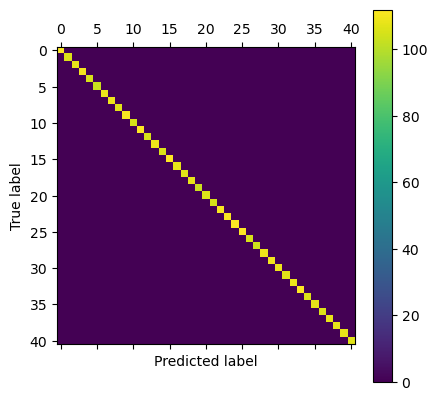

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00       112
                                   AIDS       1.00      1.00      1.00       106
                                   Acne       1.00      1.00      1.00       108
                    Alcoholic hepatitis       1.00      1.00      1.00       110
                                Allergy       1.00      1.00      1.00       105
                              Arthritis       1.00      1.00      1.00       103
                       Bronchial Asthma       1.00      1.00      1.00       109
                   Cervical spondylosis       1.00      1.00      1.00       109
                            Chicken pox       1.00      1.00      1.00       107
                    Chronic cholestasis       1.00      1.00      1.00       111
                            Common Cold       1.00      1.00      1.00       105
                           

In [141]:
classifier_logistic.fit(x_train, y_train)
y_predict = classifier_logistic.predict(x_train) # predict the result

scores = model_selection.cross_val_score(classifier_logistic, x_train, y_train, cv = 10)
print(f'For Logistic Regression, the accurracy is {round(scores.mean() * 100, 1)} +/- {round(scores.std() * 100 / (10 ** 0.5) * 1.96, 1)}%')

# Confusion Matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

<font color='red'> A logistic regressor could overkill this task...**Shall we continue to use a more complexed model?**</font>

In principle, maybe we can just use a logistic regressor if its test result is also very ideal. But for **Etudie**, we also use other classifier instead

<font color='blue'>The following training and cross validation may for etudie purpose only</font>

RandomForestClassifier

For Random Forest, the accurracy is 100.0 +/- 0.0%


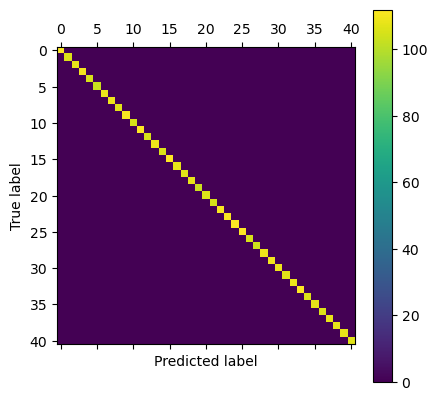

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00       112
                                   AIDS       1.00      1.00      1.00       106
                                   Acne       1.00      1.00      1.00       108
                    Alcoholic hepatitis       1.00      1.00      1.00       110
                                Allergy       1.00      1.00      1.00       105
                              Arthritis       1.00      1.00      1.00       103
                       Bronchial Asthma       1.00      1.00      1.00       109
                   Cervical spondylosis       1.00      1.00      1.00       109
                            Chicken pox       1.00      1.00      1.00       107
                    Chronic cholestasis       1.00      1.00      1.00       111
                            Common Cold       1.00      1.00      1.00       105
                           

In [142]:
classifier_RF.fit(x_train, y_train)
y_predict = classifier_RF.predict(x_train) # predict the result

scores = model_selection.cross_val_score(classifier_RF, x_train, y_train, cv = 10)
print(f'For Random Forest, the accurracy is {round(scores.mean() * 100, 1)} +/- {round(scores.std() * 100 / (10 ** 0.5) * 1.96, 1)}%')

# Confusion Matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

KNeighborsClassifier

For K-Neighbours Classifier, the accurracy is 100.0 +/- 0.0


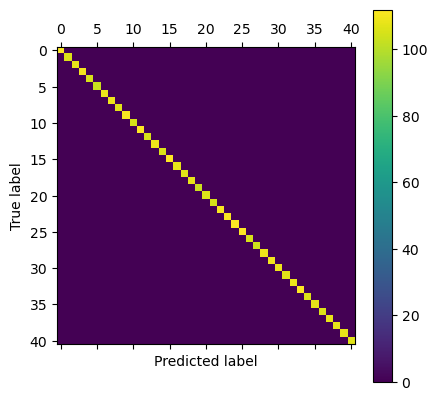

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00       112
                                   AIDS       1.00      1.00      1.00       106
                                   Acne       1.00      1.00      1.00       108
                    Alcoholic hepatitis       1.00      1.00      1.00       110
                                Allergy       1.00      1.00      1.00       105
                              Arthritis       1.00      1.00      1.00       103
                       Bronchial Asthma       1.00      1.00      1.00       109
                   Cervical spondylosis       1.00      1.00      1.00       109
                            Chicken pox       1.00      1.00      1.00       107
                    Chronic cholestasis       1.00      1.00      1.00       111
                            Common Cold       1.00      1.00      1.00       105
                           

In [143]:
classifier_KNN.fit(x_train, y_train)
y_predict = classifier_KNN.predict(x_train)

scores = model_selection.cross_val_score(classifier_KNN, x_train, y_train, cv = 10)
print(f'For K-Neighbours Classifier, the accurracy is {round(scores.mean() * 100 ,2)} +/- {round(scores.std() / (10 ** 0.5) * 1.96, 2)}')

# Confusion Matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

SVC

For SVC, the classification accurracy is 100.0 +/- 0.0


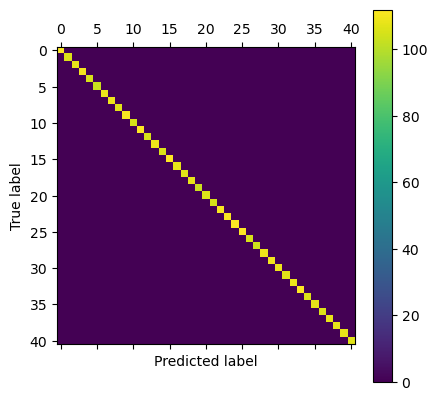

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00       112
                                   AIDS       1.00      1.00      1.00       106
                                   Acne       1.00      1.00      1.00       108
                    Alcoholic hepatitis       1.00      1.00      1.00       110
                                Allergy       1.00      1.00      1.00       105
                              Arthritis       1.00      1.00      1.00       103
                       Bronchial Asthma       1.00      1.00      1.00       109
                   Cervical spondylosis       1.00      1.00      1.00       109
                            Chicken pox       1.00      1.00      1.00       107
                    Chronic cholestasis       1.00      1.00      1.00       111
                            Common Cold       1.00      1.00      1.00       105
                           

In [144]:
classifier_SVC.fit(x_train, y_train)
y_predict = classifier_SVC.predict(x_train)

# cross validation
scores = model_selection.cross_val_score(classifier_SVC, x_train, y_train, cv = 10)
print(f'For SVC, the classification accurracy is {round(scores.mean() * 100, 2)} +/- {round(scores.std() / (10 ** 0.5) * 1.96, 2)}')

# confusion matrix 
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

*The model is a bit slow*

GradientBoostingClassifier

In [145]:
classifier_GB.fit(x_train, y_train)
y_predict = classifier_GB.predict(x_train)

# cross validation
scores = model_selection.cross_val_score(classifier_GB, x_train, y_train, cv = 10)

print(f'For Gradient Boosting Classifier, the accurracy is {round(scores.mean() * 100 , 2)}\
    +/- {round(scores.std() * 1.96 / (10 ** 0.5), 2)}%')

For Gradient Boosting Classifier, the accurracy is 100.0    +/- 0.0%


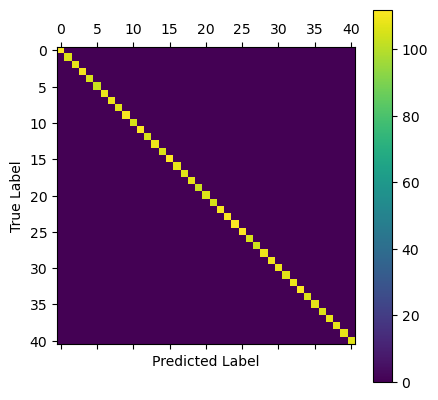

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00       112
                                   AIDS       1.00      1.00      1.00       106
                                   Acne       1.00      1.00      1.00       108
                    Alcoholic hepatitis       1.00      1.00      1.00       110
                                Allergy       1.00      1.00      1.00       105
                              Arthritis       1.00      1.00      1.00       103
                       Bronchial Asthma       1.00      1.00      1.00       109
                   Cervical spondylosis       1.00      1.00      1.00       109
                            Chicken pox       1.00      1.00      1.00       107
                    Chronic cholestasis       1.00      1.00      1.00       111
                            Common Cold       1.00      1.00      1.00       105
                           

In [146]:
# plotting confusing matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(metrics.classification_report(y_train, y_predict))

*This model is much slower...*

GaussianNB

In [147]:
classifier_NB.fit(x_train, y_train)
y_predict = classifier_NB.predict(x_train)

# Cross Validation
scores = model_selection.cross_val_score(classifier_NB, x_train, y_train, cv = 10)
print(f'Fore Gaussian Naive Bayes Model, the accurracy is {round(scores.mean() * 100, 2)} +/- {round(scores.std() * 1.96 / (10 ** 0.5), 2)}')

Fore Gaussian Naive Bayes Model, the accurracy is 100.0 +/- 0.0


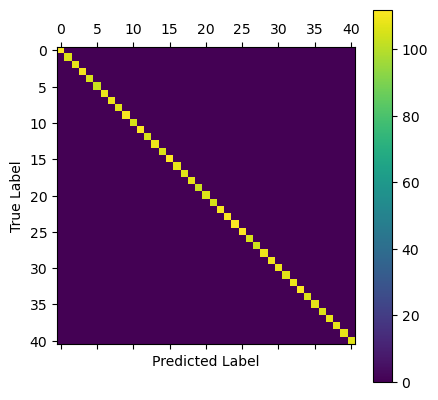

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00       112
                                   AIDS       1.00      1.00      1.00       106
                                   Acne       1.00      1.00      1.00       108
                    Alcoholic hepatitis       1.00      1.00      1.00       110
                                Allergy       1.00      1.00      1.00       105
                              Arthritis       1.00      1.00      1.00       103
                       Bronchial Asthma       1.00      1.00      1.00       109
                   Cervical spondylosis       1.00      1.00      1.00       109
                            Chicken pox       1.00      1.00      1.00       107
                    Chronic cholestasis       1.00      1.00      1.00       111
                            Common Cold       1.00      1.00      1.00       105
                           

In [148]:
# confusion matrix
cm = metrics.confusion_matrix(y_train, y_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(metrics.classification_report(y_train, y_predict))

All of the models above, including logistic regression, are overfitted. Let's see what they perform in test model.

### 4. Model Evaluation
**Precision**(PPV, positive predictive value): <font color='red'>tp / (tp + fp)</font>;
High Precision means low fp

**Recall**(sensitivity, hit rate, true positive rate): <font color='red'>tp / (tp + fn)</font>

**Accurracy**: <font color='red'>(tp + tn) / (tp + tn + fp + fn)</font>

**f1-Score**: <font color='red'>(2 * P * R) / (P + R)</font>

1. Logistic Regression

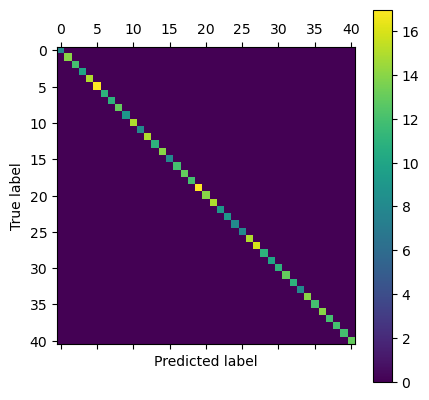

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         8
                                   AIDS       1.00      1.00      1.00        14
                                   Acne       1.00      1.00      1.00        12
                    Alcoholic hepatitis       1.00      1.00      1.00        10
                                Allergy       1.00      1.00      1.00        15
                              Arthritis       1.00      1.00      1.00        17
                       Bronchial Asthma       1.00      1.00      1.00        11
                   Cervical spondylosis       1.00      1.00      1.00        11
                            Chicken pox       1.00      1.00      1.00        13
                    Chronic cholestasis       1.00      1.00      1.00         9
                            Common Cold       1.00      1.00      1.00        15
                           

In [149]:
y_final_predict = classifier_logistic.predict(x_test)

cm = metrics.confusion_matrix(y_test, y_final_predict)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_test, y_final_predict))


**If we only use patient symptom data for diagnosis, a logistic regression might be enough...**<br>
**However, it might be a bit unrealistic because the disease diagnosis task is a relative complexed one**<br>
**<font color='red'>This dataset seems to be a bit ideal.</font>**

2. RandomForestClassifier

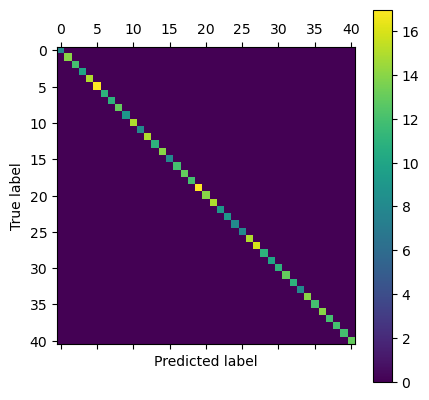

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         8
                                   AIDS       1.00      1.00      1.00        14
                                   Acne       1.00      1.00      1.00        12
                    Alcoholic hepatitis       1.00      1.00      1.00        10
                                Allergy       1.00      1.00      1.00        15
                              Arthritis       1.00      1.00      1.00        17
                       Bronchial Asthma       1.00      1.00      1.00        11
                   Cervical spondylosis       1.00      1.00      1.00        11
                            Chicken pox       1.00      1.00      1.00        13
                    Chronic cholestasis       1.00      1.00      1.00         9
                            Common Cold       1.00      1.00      1.00        15
                           

In [150]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, classifier_RF.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_test, classifier_RF.predict(x_test)))

3. KNeighborsClassifier

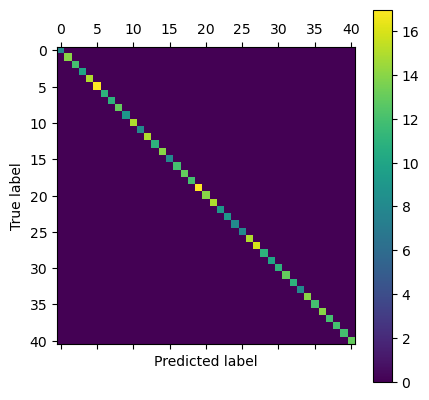

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         8
                                   AIDS       1.00      1.00      1.00        14
                                   Acne       1.00      1.00      1.00        12
                    Alcoholic hepatitis       1.00      1.00      1.00        10
                                Allergy       1.00      1.00      1.00        15
                              Arthritis       1.00      1.00      1.00        17
                       Bronchial Asthma       1.00      1.00      1.00        11
                   Cervical spondylosis       1.00      1.00      1.00        11
                            Chicken pox       1.00      1.00      1.00        13
                    Chronic cholestasis       1.00      1.00      1.00         9
                            Common Cold       1.00      1.00      1.00        15
                           

In [151]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, classifier_KNN.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_test, classifier_KNN.predict(x_test)))

4. SVC

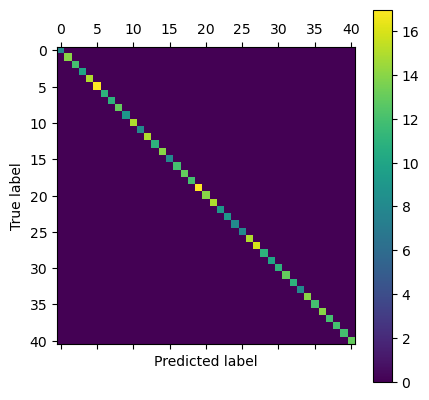

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         8
                                   AIDS       1.00      1.00      1.00        14
                                   Acne       1.00      1.00      1.00        12
                    Alcoholic hepatitis       1.00      1.00      1.00        10
                                Allergy       1.00      1.00      1.00        15
                              Arthritis       1.00      1.00      1.00        17
                       Bronchial Asthma       1.00      1.00      1.00        11
                   Cervical spondylosis       1.00      1.00      1.00        11
                            Chicken pox       1.00      1.00      1.00        13
                    Chronic cholestasis       1.00      1.00      1.00         9
                            Common Cold       1.00      1.00      1.00        15
                           

In [152]:
# confusion matrix 
cm = metrics.confusion_matrix(y_test, classifier_SVC.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(metrics.classification_report(y_test, classifier_SVC.predict(x_test)))

*The model is a bit slow*

5. GradientBoostingClassifier

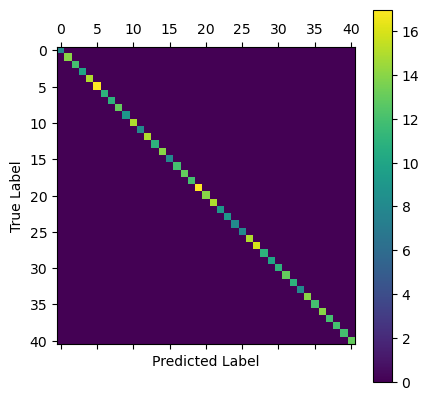

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         8
                                   AIDS       1.00      1.00      1.00        14
                                   Acne       1.00      1.00      1.00        12
                    Alcoholic hepatitis       1.00      1.00      1.00        10
                                Allergy       1.00      1.00      1.00        15
                              Arthritis       1.00      1.00      1.00        17
                       Bronchial Asthma       1.00      1.00      1.00        11
                   Cervical spondylosis       1.00      1.00      1.00        11
                            Chicken pox       1.00      1.00      1.00        13
                    Chronic cholestasis       1.00      1.00      1.00         9
                            Common Cold       1.00      1.00      1.00        15
                           

In [153]:
# plotting confusing matrix
cm = metrics.confusion_matrix(y_test, classifier_GB.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(metrics.classification_report(y_test, classifier_GB.predict(x_test)))

*This model is much slower...*

GaussianNB

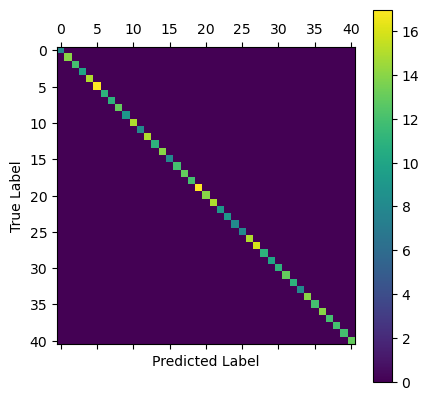

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         8
                                   AIDS       1.00      1.00      1.00        14
                                   Acne       1.00      1.00      1.00        12
                    Alcoholic hepatitis       1.00      1.00      1.00        10
                                Allergy       1.00      1.00      1.00        15
                              Arthritis       1.00      1.00      1.00        17
                       Bronchial Asthma       1.00      1.00      1.00        11
                   Cervical spondylosis       1.00      1.00      1.00        11
                            Chicken pox       1.00      1.00      1.00        13
                    Chronic cholestasis       1.00      1.00      1.00         9
                            Common Cold       1.00      1.00      1.00        15
                           

In [154]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, classifier_NB.predict(x_test))
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(metrics.classification_report(y_test, classifier_NB.predict(x_test)))

All of the models above, including logistic regression, are overfitted, even in testing data.

<font color = 'red'>Therefore, if we have to figure out which one is the best, maybe the only answer would be the <strong>logistic regression </strong>model</font>

**Feature Importance**

In [155]:
importances = classifier_RF.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by RF:")
for ind in range(x.shape[1]):
  print ("{0} : {1}".format(x.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by RF:
 muscle_pain : 0.0195
 chest_pain : 0.0164
itching : 0.0151
 yellowing_of_eyes : 0.0151
 altered_sensorium : 0.0149
 diarrhoea : 0.0144
 dark_urine : 0.0144
 lack_of_concentration : 0.014
 family_history : 0.0135
 weight_loss : 0.0131
 mild_fever : 0.0129
 vomiting : 0.0128
 mucoid_sputum : 0.0126
 unsteadiness : 0.0125
 joint_pain : 0.0123
 red_spots_over_body : 0.012
 nausea : 0.012
 fatigue : 0.0119
 chills : 0.0117
 loss_of_balance : 0.0117
 internal_itching : 0.0117
 loss_of_appetite : 0.0114
 abdominal_pain : 0.0114
 high_fever : 0.0114
 bladder_discomfort : 0.0114
 muscle_weakness : 0.0113
 headache : 0.0112
 sweating : 0.0111
 stomach_pain : 0.0109
 coma : 0.0108
 irritability : 0.0107
 dischromic _patches : 0.0105
 pain_behind_the_eyes : 0.0105
 rusty_sputum : 0.0104
 spotting_ urination : 0.0103
 breathlessness : 0.0103
 back_pain : 0.0102
 nodal_skin_eruptions : 0.0096
 patches_in_throat : 0.0092
 blackheads : 0.0091
 fluid_overload : 0.0091

### 5. Insigits & Conclusion

**1. It seems that logistic regression is enough to diagnose some common disease. <font color='red'>However, the usability of this model is still needed to be furtherly verified due to the possible overly-ideal.</font>**<br>
**2. muscle pain, chest pain, itching, yellowing of eyes, and altered sensorium are 5 symptoms with high specificity.**